In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import scipy as scipy
import scipy.stats as sc
import numpy as np
import pandas as pd
import os
import re
from calendar import isleap

In [2]:
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007          
    

In [3]:
one_file = scipy.io.loadmat('../aaron_aht_stuff/transients_by_month/2017_3_iTE.mat')

times = pd.date_range('2001-01-01', '2018-12-31 18:00:00', freq='6H')

dataDir = '../aaron_aht_stuff/transients_by_month/'

all_te = np.zeros((len(times), 361))

years = range(2001, 2019)
months = range(1, 13)

tes_list = []

for year in years:
    #print(year)
    for month in months:
    
    
        file_name = f'{year}_{month}_iTE.mat'
    
        data = scipy.io.loadmat(dataDir+file_name)
        
        len_data = len(data['iTE'][:,0])

        if month == 12:
            
            len_time = len(pd.date_range(f'{year}-{month}-01', f'{year + 1}-1-01 00:00:00', freq='6H'))
        
        else:
            len_time = len(pd.date_range(f'{year}-{month}-01', f'{year}-{(month + 1)}-01 00:00:00', freq='6H'))
        
        if (len_time - len_data) != 1:
            print(f'{year}_{month}')
        #print(f'Data is: {len_data} and time is: {len_time}')

        #all_te[time_idx,:] = data['iTE']
        tes_list.append(data['iTE'])



2004_2
2008_2
2012_2
2016_2


In [4]:
tes_array = np.vstack(np.array([np.array(xi) for xi in tes_list]))

orig_times = pd.date_range('2001-01-01', '2018-12-31 18:00:00', freq='6H')
times = orig_times[(orig_times.day != 29) | (orig_times.month != 2)]

print(len(times))
print(len(orig_times))

lats = one_file['lat'].flatten()


te_ds = xr.Dataset(
                        data_vars = dict(
                            te_aht=(['time', 'latitude'], tes_array),
                        ),
                        coords=dict(
                            time = times,
                            latitude=lats)
    )

26280
26296


<ipython-input-4-c59c8fddae23>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tes_array = np.vstack(np.array([np.array(xi) for xi in tes_list]))


In [91]:
#te_ds.to_netcdf('te_ds.nc')

In [5]:
te_ds_conv = te_ds.differentiate('latitude')

te_ds_conv

<xarray.Dataset>
Dimensions:   (time: 26280, latitude: 361)
Coordinates:
  * time      (time) datetime64[ns] 2001-01-01 ... 2018-12-31T18:00:00
  * latitude  (latitude) float64 90.0 89.5 89.0 88.5 ... -88.5 -89.0 -89.5 -90.0
Data variables:
    te_aht    (time, latitude) float64 2.182e+12 3.659e+12 ... 3.02e+11

In [6]:
aht_ds = xr.open_dataset('../aht_time_series/era5_aht_time_series_full.nc')

In [7]:
aht_ds

<xarray.Dataset>
Dimensions:                     (time: 63184, latitude: 361)
Coordinates:
  * time                        (time) datetime64[ns] 1979-01-01 ... 2022-03-...
  * latitude                    (latitude) float64 90.0 89.5 ... -89.5 -90.0
Data variables: (12/18)
    total_aht                   (time, latitude) float64 ...
    eddy_aht                    (time, latitude) float64 ...
    mmc_aht                     (time, latitude) float64 ...
    total_aht_no_seasons        (time, latitude) float64 ...
    eddy_aht_no_seasons         (time, latitude) float64 ...
    mmc_aht_no_seasons          (time, latitude) float64 ...
    ...                          ...
    total_aht_dry               (time, latitude) float64 ...
    eddy_aht_dry                (time, latitude) float64 ...
    mmc_aht_dry                 (time, latitude) float64 ...
    total_aht_no_seasons_dry    (time, latitude) float64 ...
    eddy_aht_no_seasons_dry     (time, latitude) float64 ...
    mmc_aht_no_seasons_dry      (time, latitude) float64 ...

In [103]:
mse_tendency_ds = xr.open_dataset('../MSE_zonal_tendency_no_ke.nc').sel(time=slice('1979-01-01', '2018-12-31'))

ps_ds = xr.open_dataset('../era5_raw_data/average_surf_pres.nc').sp
ps_zon_mean = ps_ds.mean('lon').values

mse_tendency_ds = mse_tendency_ds.interp(latitude=lats)  / 6 / 3600 * ps_zon_mean / g

In [104]:
mse_tendency_ds_subset_te = mse_tendency_ds.sel(time=slice('2001-01-01', '2018-12-31'))

mse_tendency_ds_subset_te = mse_tendency_ds_subset_te.sel(time=~((mse_tendency_ds_subset_te.time.dt.month == 2) & (mse_tendency_ds_subset_te.time.dt.day == 29)))

mse_tendency_ds_subset_te_djf = mse_tendency_ds_subset_te.sel(time=mse_tendency_ds_subset_te.time.dt.month.isin([12, 1, 2]))
mse_tendency_ds_subset_te_jja = mse_tendency_ds_subset_te.sel(time=mse_tendency_ds_subset_te.time.dt.month.isin([6, 7, 8]))

#mse_tendency_ds_subset_te.time

te_ds_conv_subset_djf = te_ds_conv.sel(time=mse_tendency_ds_subset_te_djf.time)
te_ds_conv_subset_jja = te_ds_conv.sel(time=mse_tendency_ds_subset_te_jja.time)

In [105]:
mse_tendency_ds_djf = mse_tendency_ds.sel(time=mse_tendency_ds.time.dt.month.isin([12, 1, 2]))
mse_tendency_ds_jja = mse_tendency_ds.sel(time=mse_tendency_ds.time.dt.month.isin([6, 7, 8]))

In [106]:
aht_ds_subset_djf = aht_ds.sel(time=mse_tendency_ds_djf.time)
aht_ds_subset_jja = aht_ds.sel(time=mse_tendency_ds_jja.time)

In [107]:
aht_ds_conv_djf = aht_ds_subset_djf.differentiate('latitude')
aht_ds_conv_jja = aht_ds_subset_jja.differentiate('latitude')

In [108]:
mass_flux_ds = xr.open_mfdataset('../era5_data/mass_flux/*').sel(time=slice('1980-01-01', '2014-12-31'))

mass_flux_ds = mass_flux_ds.compute()


geom_mass = 2 * np.pi * np.cos(np.deg2rad(mass_flux_ds.latitude.values)) * a / g

mass_aht = mass_flux_ds.mass_aht * geom_mass

mass_aht = mass_aht.interp(latitude=aht_ds.latitude) #To get the right latitudes

In [109]:
mass_aht_djf = mass_aht.sel(time=mass_aht.time.dt.month.isin([12, 1, 2]))
mass_aht_jja = mass_aht.sel(time=mass_aht.time.dt.month.isin([6, 7, 8]))

In [110]:

mass_grad_djf = mass_aht_djf.differentiate('latitude')
full_grad_djf = (aht_ds_subset_djf.total_aht + mass_aht_djf).differentiate('latitude')
aht_grad_djf = aht_ds_subset_djf.total_aht.differentiate('latitude')
eddy_grad_djf = aht_ds_subset_djf.eddy_aht.differentiate('latitude')

corrs_mass_djf = -xr.corr(mse_tendency_ds_djf.MSE_tendency, mass_grad_djf, dim='time')
corrs_total_mass_djf = -xr.corr(mse_tendency_ds_djf.MSE_tendency, full_grad_djf, dim='time')
corrs_total_djf = -xr.corr(mse_tendency_ds_djf.MSE_tendency, aht_grad_djf, dim='time')
corrs_eddy_djf = -xr.corr(mse_tendency_ds_djf.MSE_tendency, eddy_grad_djf, dim='time')

corrs_te_djf = -xr.corr(te_ds_conv_subset_djf.te_aht, mse_tendency_ds_subset_te_djf.MSE_tendency, dim='time')

mass_grad_jja = mass_aht_jja.differentiate('latitude')
full_grad_jja = (aht_ds_subset_jja.total_aht + mass_aht_jja).differentiate('latitude')
aht_grad_jja = aht_ds_subset_jja.total_aht.differentiate('latitude')
eddy_grad_jja = aht_ds_subset_jja.eddy_aht.differentiate('latitude')

corrs_mass_jja = -xr.corr(mse_tendency_ds_jja.MSE_tendency, mass_grad_jja, dim='time')
corrs_total_mass_jja = -xr.corr(mse_tendency_ds_jja.MSE_tendency, full_grad_jja, dim='time')
corrs_total_jja = -xr.corr(mse_tendency_ds_jja.MSE_tendency, aht_grad_jja, dim='time')
corrs_eddy_jja = -xr.corr(mse_tendency_ds_jja.MSE_tendency, eddy_grad_jja, dim='time')

corrs_te_jja = -xr.corr(te_ds_conv_subset_jja.te_aht, mse_tendency_ds_subset_te_jja.MSE_tendency, dim='time')



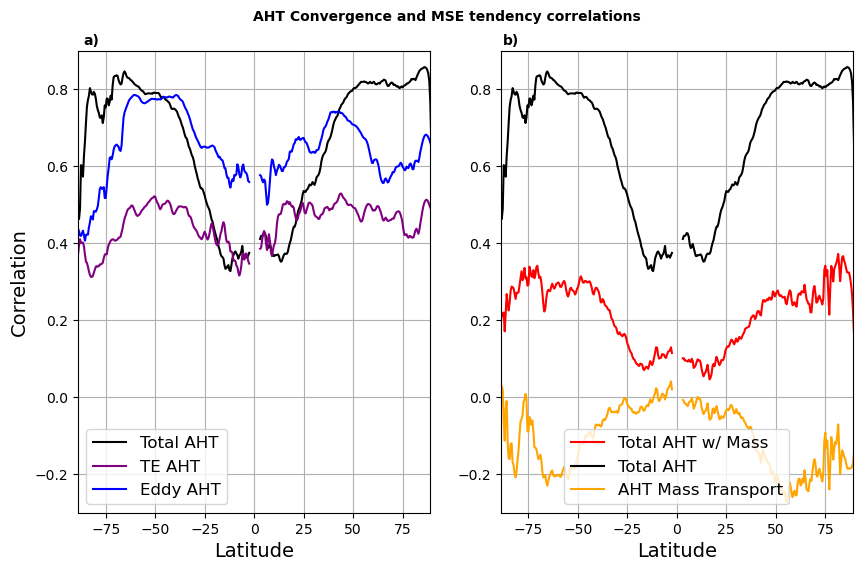

In [131]:
panel_order = [['B', 'A']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

(corrs_total_mass_djf[:175]).plot(ax=axs['A'], color='red', label='Total AHT w/ Mass')
(corrs_total_mass_jja[185:]).plot(ax=axs['A'], color='red')
(corrs_total_djf[:175]).plot(ax=axs['A'], color='k', label='Total AHT')
(corrs_total_jja[185:]).plot(ax=axs['A'], color='k')
(corrs_mass_djf[:175]).plot(ax=axs['A'], color='orange', label='AHT Mass Transport')
(corrs_mass_jja[185:]).plot(ax=axs['A'], color='orange')

#axs['A'].plot(np.linspace(-90, 90, 361), corrs_total, label='Total AHT', color='k')
#axs['A'].plot(np.linspace(-90, 90, 361), corrs_mass, color='b',
              #label='AHT Mass Transport')
#axs['B'].plot(np.linspace(-90, 90, 361), corrs_total_mass, label='Total AHT w/ mass')

(corrs_total_djf[:175]).plot.line(ax=axs['B'], label='Total AHT', color='k')
(corrs_total_jja[185:]).plot.line(ax=axs['B'], color='k')
(corrs_te_djf[:175]).plot.line(ax=axs['B'],label='TE AHT', color='purple')
(corrs_te_jja[185:]).plot.line(ax=axs['B'], color='purple')
(corrs_eddy_djf[:175]).plot.line(ax=axs['B'],label='Eddy AHT', color='blue')
(corrs_eddy_jja[185:]).plot.line(ax=axs['B'], color='blue')

axs['A'].grid()
axs['B'].grid()

axs['A'].legend(loc=0, fontsize=12)
axs['B'].legend(loc=0, fontsize=12)

axs['A'].set_xlim([-89, 89])
axs['B'].set_xlim([-89, 89])

axs['B'].set_ylabel('Correlation', fontsize=14)
#axs['B'].set_ylabel('Correlation', fontsize=12)
axs['A'].set_xlabel('Latitude', fontsize=14)
axs['B'].set_xlabel('Latitude', fontsize=14)

axs['A'].set_ylim([-0.3, 0.9])
axs['B'].set_ylim([-0.3, 0.9])
#axs['A'].set_title('Standard Deviations')
#axs['B'].set_title('Correlations with \n column MSE tendency')
fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.55, 0.89, 'b)', fontweight='semibold')
fig.text(0.3, 0.93, 'AHT Convergence and MSE tendency correlations', fontweight='semibold')
#plt.savefig('figures/aht_mse_tend_corrs', bbox_inches='tight')

plt.show()

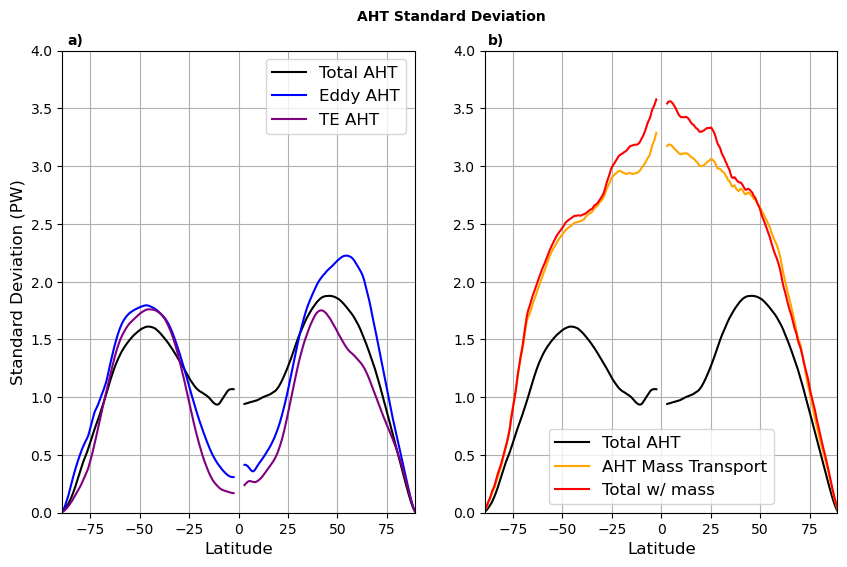

In [136]:
panel_order = [['B', 'A']]
fig, axs = plt.subplot_mosaic(panel_order, figsize=(10, 6))

aht_ds_djf = aht_ds.sel(time=aht_ds.time.dt.month.isin([12, 1, 2]))
aht_ds_jja = aht_ds.sel(time=aht_ds.time.dt.month.isin([6, 7, 8]))
te_ds_djf = te_ds.sel(time=te_ds.time.dt.month.isin([12, 1, 2]))
te_ds_jja = te_ds.sel(time=te_ds.time.dt.month.isin([6, 7, 8]))
mass_aht_djf = mass_aht.sel(time=mass_aht.time.dt.month.isin([12, 1, 2]))
mass_aht_jja = mass_aht.sel(time=mass_aht.time.dt.month.isin([6, 7, 8]))

axs['A'].plot(aht_ds_djf.latitude[:175], np.std(aht_ds_djf.total_aht, axis=0)[:175] / 1e15,
         color='k', label='Total AHT')
axs['A'].plot(aht_ds_djf.latitude[185:], np.std(aht_ds_jja.total_aht, axis=0)[185:] / 1e15,
         color='k')

axs['A'].plot(aht_ds_djf.latitude[:175], np.std(mass_aht_djf, axis=0)[:175] / 1e15,
         color='orange', label='AHT Mass Transport')
axs['A'].plot(aht_ds_djf.latitude[185:], np.std(mass_aht_jja, axis=0)[185:] / 1e15,
         color='orange')

axs['A'].plot(aht_ds_djf.latitude[:175], np.std(mass_aht_djf + aht_ds_djf.total_aht, axis=0)[:175] / 1e15,
         color='r', label='Total w/ mass')
axs['A'].plot(aht_ds_djf.latitude[185:], np.std(mass_aht_jja + aht_ds_jja.total_aht, axis=0)[185:] / 1e15,
         color='r')

axs['B'].plot(aht_ds_djf.latitude[:175], np.std(aht_ds_djf.total_aht, axis=0)[:175] / 1e15,
         color='k', label='Total AHT')
axs['B'].plot(aht_ds_djf.latitude[185:], np.std(aht_ds_jja.total_aht, axis=0)[185:] / 1e15,
         color='k')

axs['B'].plot(aht_ds_djf.latitude[:175], np.std(aht_ds_djf.eddy_aht, axis=0)[:175] / 1e15,
         color='blue', label='Eddy AHT')
axs['B'].plot(aht_ds_djf.latitude[185:], np.std(aht_ds_jja.eddy_aht, axis=0)[185:] / 1e15,
         color='blue')

axs['B'].plot(aht_ds_djf.latitude[:175], (te_ds_djf.te_aht.std('time')[:175] / 1e15),
         color='purple', label='TE AHT')

axs['B'].plot(aht_ds_djf.latitude[185:], (te_ds_jja.te_aht.std('time')[185:] / 1e15),
         color='purple',)

axs['A'].grid()
axs['B'].grid()

axs['A'].legend(loc=0, fontsize=12)
axs['B'].legend(loc=0, fontsize=12)

axs['A'].set_xlim([-89, 89])
axs['B'].set_xlim([-89, 89])

axs['B'].set_ylabel('Standard Deviation (PW)', fontsize=12)
#axs['B'].set_ylabel('Correlation', fontsize=12)
axs['A'].set_xlabel('Latitude', fontsize=12)
axs['B'].set_xlabel('Latitude', fontsize=12)

axs['A'].set_ylim([0, 4])
axs['B'].set_ylim([0, 4])
#axs['A'].set_title('Standard Deviations')
#axs['B'].set_title('Correlations with \n column MSE tendency')
fig.text(0.13, 0.89, 'a)', fontweight='semibold')
fig.text(0.55, 0.89, 'b)', fontweight='semibold')
fig.text(0.42, 0.93, 'AHT Standard Deviation', fontweight='semibold')

#plt.savefig('figures/aht_comparisons_std_dev', bbox_inches='tight')

plt.show()

In [113]:
aaron_corrs = scipy.io.loadmat('DJF_JJA_AHTMF_CORR_STD.mat')


aaron_corrs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'CORR_AHTDIVMF_TEN', 'CORR_AHTDIVTOT_TEN', 'CORR_AHTDIV_TEN', 'STD_AHT', 'STD_AHTMF', 'STD_AHT_with_MF', 'lat'])

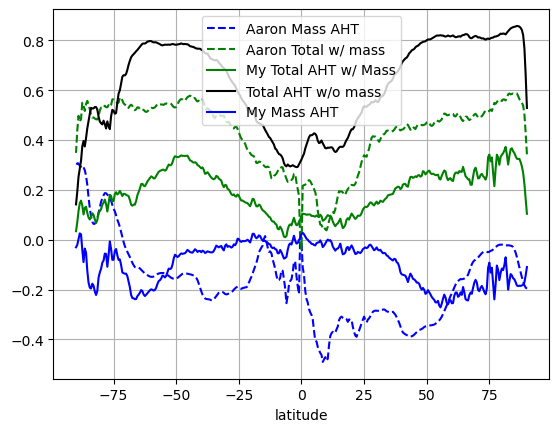

In [116]:
aaron_lat = aaron_corrs['lat'].flatten()

#plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIV_TEN'].flatten(), label='Aaron Total w/o mass')
plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIVMF_TEN'].flatten(), '--', color='b', label='Aaron Mass AHT')
plt.plot(aaron_lat, aaron_corrs['CORR_AHTDIVTOT_TEN'].flatten(), '--', color='g', label='Aaron Total w/ mass')

(corrs_total_mass_djf).plot(color='g', label='My Total AHT w/ Mass')
(corrs_total_djf).plot(color='k', label='Total AHT w/o mass')
(corrs_mass_djf).plot(color='b', label='My Mass AHT')
#corrs_eddy_mse.plot.line(label='Eddy AHT corr')

plt.legend(loc=0)
plt.grid()
plt.show()

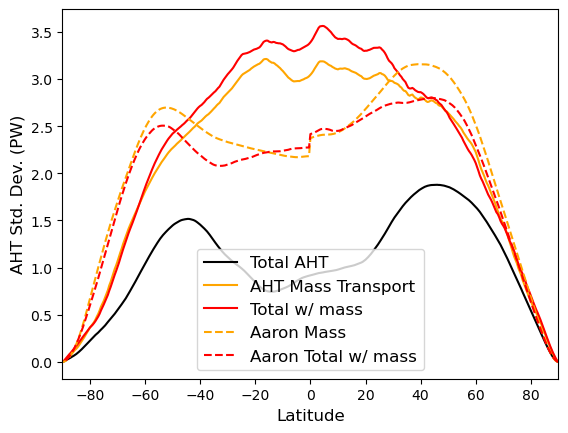

In [117]:
plt.plot(np.linspace(90, -90, 361), np.std(aht_ds_djf.total_aht, axis=0) / 1e15,
         color='k', label='Total AHT')

plt.plot(np.linspace(90, -90, 361), np.std(mass_aht_djf, axis=0) / 1e15,
         color='orange', label='AHT Mass Transport')

plt.plot(np.linspace(90, -90, 361), np.std(mass_aht_djf + aht_ds_djf.total_aht, axis=0) / 1e15,
         color='r', label='Total w/ mass')

#plt.plot(aaron_lat, aaron_corrs['STD_AHT'].flatten() / 1e15, '--', color='k', label='Aaron Total w/o mass')
plt.plot(aaron_lat, aaron_corrs['STD_AHTMF'].flatten() / 1e15, '--', color='orange', label='Aaron Mass')
plt.plot(aaron_lat, aaron_corrs['STD_AHT_with_MF'].flatten() / 1e15, '--', color='r', label='Aaron Total w/ mass')

plt.legend(loc=0, fontsize=12)

plt.xlim([-90, 90])

plt.xlabel('Latitude', fontsize=12)
plt.ylabel('AHT Std. Dev. (PW)', fontsize=12)

#plt.savefig('figures/aht_std_dev_comparison_to_aaron', bbox_inches='tight')

plt.show()

In [140]:
te_ds.sel(time=te_ds.time.dt.month.isin([12, 1, 2])).sel(latitude=50).std('time')

<xarray.Dataset>
Dimensions:   ()
Coordinates:
    latitude  float64 50.0
Data variables:
    te_aht    float64 1.565e+15

In [ ]:
####OLD####